# **Importing data from Kaggle**

In [1]:
! pip install -q kaggle wordcloud gensim

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"goutammunda","key":"1187c12f17b726c818f5e3926d97b25f"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 652kB/s]
100% 593k/593k [00:00<00:00, 652kB/s]


# **Unzipping the dataset**

In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/nlp-getting-started.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# **Necessary Imports**

In [6]:
# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer

# Data Processing
import numpy as np
import pandas as pd
from tqdm import tqdm


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#Embeddings
from gensim.models import Word2Vec

# Model
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
# from tensorflow.keras.preprocessing.text import one_hot
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# huggingface
from transformers import BertTokenizer, BertForSequenceClassification, AdamW


In [7]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Loading/Exploring Dataset**

In [8]:
df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print(f"Train Data Shape: {df.shape}")
print(f"Test Data Shape: {test_df.shape}")

Train Data Shape: (7613, 5)
Test Data Shape: (3263, 4)


In [9]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
df.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


## Imputing Missing values

In [11]:
# imputing missing value in keyword column using named entity recognition

# ner = pipeline("ner", grouped_entities=True)
# tried to perform ner on the missing values for keyword did not get the ideal response, now I will manually impute keywords for these missig

to_impute = df[df['keyword'].isnull() == True]
indices = to_impute.index.values
texts = to_impute['text'].tolist()
texts[0], indices[0]

('Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all', 0)

In [12]:
# for i in range(len(to_impute)):
#   print(texts[i], indices[i])

In [13]:

indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
           20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 7583, 7584, 7585, 7586, 7587,
           7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599,
           7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611,
           7612]

keywords = [
    "earthquake", "forest fire", "evacuation", "wildfires", "wildifres", "wildifires",
    "flood", "fire", "evacuation", "tornado", "heatwave", "flooding", "flooding",
    "flooding", "crash", "what's", "love", "summer", "car", "what", "ridiculous",
    "london", "skiing", "wonderful", "lOOOOOOl", "eat", "nyc", "girlfriend",
    "cooool", "pasta", "end", "bomb", "flooding", "seismic", "sirens", "killed",
    "earthquake", "cyclone", "heatwave", "bomber", "asleep", "exploded", "flooding",
    "thunderstorm", "aircraft", "collided", "earthquake", "evacuation", "oilspill",
    "tornado", "quarantine", "fire", "bomb", "bomber", "tornado", "collapse",
    "wildfires", "volcano", "collided", "widlfire"
]

# Impute missing values
for idx, keyword in zip(indices, keywords):
    df.at[idx, 'keyword'] = keyword

df.head()



,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,forest fire,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,wildifres,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
df.isnull().sum()

,0
id,0
keyword,1
location,2533
text,0
target,0


In [15]:
df[df['keyword'].isnull() == True]  # dropping this column not use full
df.dropna(inplace=True)
df.isnull().sum()

,0
id,0
keyword,0
location,0
text,0
target,0


# **Preprocessing Texts**

In [16]:
stemmer = SnowballStemmer(language='english')
corpus = []

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # removes URLs
    text = re.sub(r'<.*?>', '', text)  # removes HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # removes non-alphabetic characters
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    # Removing stop words
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]

    # Removing duplicates while preserving order
    unique_tokens = []
    for token in tokens:
        if token not in unique_tokens:
            unique_tokens.append(token)

    preprocessed_text = ' '.join(unique_tokens)
    corpus.append(preprocessed_text)
    return preprocessed_text

In [17]:
df['processed_text'] = df['text'].apply(preprocess_text)
df.head()

,id,keyword,location,text,target,processed_text
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesal market ablaz
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,alway tri bring heavi metal rt
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaz break newsnigeria flag set ablaz aba
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,cri set ablaz
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaz


# **EDA**

In [18]:
print(f"Final Train data shape: {df.shape}")
print(f"Final Test data shape: {test_df.shape}")

Final Train data shape: (5080, 6)
Final Test data shape: (3263, 4)


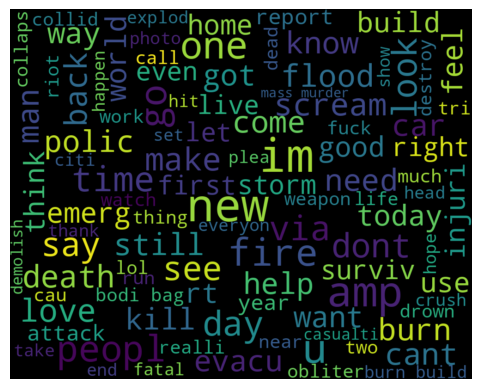

In [19]:
text = " ".join(review for review in df.processed_text)

# Generate a word cloud image
wordcloud = WordCloud(
    height=800,
    width=1000,
    max_words=100,
    max_font_size=100,
    stopwords=STOPWORDS,
    background_color="black",
    ).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

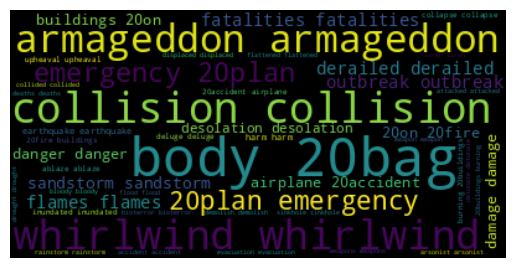

In [20]:
text = " ".join(str(word) for word in df.keyword)

# Generate a word cloud image
wordcloud = WordCloud(background_color="black").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Machine Learning**

## Vectorizer


In [21]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
# X = vectorizer.fit_transform(df['processed_text']).toarray()
# y = df['target'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")

## Trainin Model

In [22]:
# model training

# lr = LogisticRegression()
# rf = RandomForestClassifier(n_estimators=100)
# svm = SVC(C=1, kernel='linear')
#
# lr.fit(X_train, y_train)
# rf.fit(X_train, y_train)
# svm.fit(X_train, y_train)

In [23]:
# lr_preds = lr.predict(X_test)
# print(classification_report(y_test, lr_preds))

In [24]:
# rf_preds = lr.predict(X_test)
# print(classification_report(y_test, rf_preds))

In [25]:
# svm_preds = lr.predict(X_test)
# print(classification_report(y_test, svm_preds))

In [26]:
# test_df['processed_text'] = test_df['text'].apply(preprocess_text)
# test_X = vectorizer.transform(test_df['processed_text']).toarray()
# test_preds_lr = lr.predict(test_X)
# test_preds_rf = rf.predict(test_X)
# test_preds_svm = svm.predict(test_X)

In [27]:
# basic_lr_df = pd.DataFrame({'id':test_df['id'],
#                             'target': test_preds_lr})

# basic_rf_df = pd.DataFrame({'id':test_df['id'],
#                             'target': test_preds_rf})

# basic_svm_df = pd.DataFrame({'id':test_df['id'],
#                             'target': test_preds_svm})


# **Bidierctional Encoder Representation from Transformers (BERT)**

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
tokenizer("Hello World")

{'input_ids': [101, 7592, 2088, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [30]:
def tokenization(text):
  return tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors='pt')


In [31]:
tokenized = df['text'].apply(lambda x:tokenization(x))

input_ids = torch.cat([t['input_ids'] for t in tokenized])
attention_masks = torch.cat([t['attention_mask'] for t in tokenized])
labels = torch.tensor(df['target'].values)

In [32]:
# Split data into train and validation sets

train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42
)

In [33]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=32)

In [34]:
train_data[1]

(tensor([  101,  1030, 19296,  1035, 27669,  2015,  2017,  2488,  2191,  2035,
          2115,  7171,  4826,  3426,  1045,  1005,  1049,  3405,  1998,  7311,
          2097,  2022,  6908,  4826,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [35]:
optimizer = AdamW(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [37]:
from tqdm import tqdm

# Number of training epochs
epochs = 10

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Training
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}"):
        batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")

    # Validation
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in tqdm(val_dataloader, desc="Validation"):
        batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)

        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        total_eval_accuracy += (preds == batch_labels).cpu().numpy().mean()

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print(f"Validation Accuracy: {avg_val_accuracy}")

    avg_val_loss = total_eval_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_val_loss}")

Training Epoch 1: 100%|██████████| 127/127 [01:22<00:00,  1.54it/s]


Average training loss: 0.47851143132044577


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Validation Accuracy: 0.8297526041666666
Validation Loss: 0.435896931681782


Training Epoch 2: 100%|██████████| 127/127 [01:22<00:00,  1.55it/s]


Average training loss: 0.32277660277180786


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Validation Accuracy: 0.8180338541666666
Validation Loss: 0.44605485117062926


Training Epoch 3: 100%|██████████| 127/127 [01:22<00:00,  1.54it/s]


Average training loss: 0.220471123424102


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


Validation Accuracy: 0.7991536458333334
Validation Loss: 0.5574540635570884


Training Epoch 4: 100%|██████████| 127/127 [01:22<00:00,  1.54it/s]


Average training loss: 0.16104957542022852


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


Validation Accuracy: 0.7662760416666666
Validation Loss: 0.8230689894407988


Training Epoch 5: 100%|██████████| 127/127 [01:22<00:00,  1.54it/s]


Average training loss: 0.1271072735690959


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


Validation Accuracy: 0.81640625
Validation Loss: 0.7627372583374381


Training Epoch 6: 100%|██████████| 127/127 [01:22<00:00,  1.54it/s]


Average training loss: 0.11869231445208837


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Validation Accuracy: 0.7718098958333334
Validation Loss: 0.8932496262714267


Training Epoch 7: 100%|██████████| 127/127 [01:22<00:00,  1.54it/s]


Average training loss: 0.1004358941568135


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


Validation Accuracy: 0.8157552083333334
Validation Loss: 0.7014513560570776


Training Epoch 8: 100%|██████████| 127/127 [01:22<00:00,  1.54it/s]


Average training loss: 0.11849682945501441


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


Validation Accuracy: 0.81640625
Validation Loss: 0.6994823645800352


Training Epoch 9: 100%|██████████| 127/127 [01:22<00:00,  1.54it/s]


Average training loss: 0.08602119848410797


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]


Validation Accuracy: 0.8095703125
Validation Loss: 0.838184904307127


Training Epoch 10: 100%|██████████| 127/127 [01:22<00:00,  1.54it/s]


Average training loss: 0.0793788002347427


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]

Validation Accuracy: 0.791015625
Validation Loss: 1.0488903131335974


In [38]:
def predict(text):
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    return prediction

In [39]:
y_preds = []
for text in tqdm(test_df['text']):
    y_preds.append(predict(text))

100%|██████████| 3263/3263 [00:35<00:00, 92.02it/s]


In [40]:
len(y_preds)

3263

In [41]:
bert_df = pd.DataFrame({'id':test_df['id'],
                            'target': y_preds})

In [42]:
bert_df.to_csv('bert_10Epochs.csv', index=False)